In [32]:
import numpy as np
# Set up matplotlib
import matplotlib.pyplot as plt


#from astropy.visualization import time_support
#from astropy.timeseries import TimeSeries

#%matplotlib notebook 
#import matplotlib.image as mpimg

import pandas as pd

from astropy.io import fits
from astropy.utils.data import download_file

import os
import glob
#import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output

import time
import random

#%matplotlib inline
plt.rcParams.update({'font.size':15})

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats

In [33]:
image_list = []
n = 0

filepath = "..\\RV Uma\\2022_03_20\\Blue\\"
for file in glob.glob(filepath+"Reduced_RV_Uma_Light_Blue_*.fits"): #The 'D' stops it picking up past master_frames
    image_list.append(file)
    n=n+1
print("\n".join(image_list))

..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_001.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_002.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_003.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_004.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_005.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_006.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_007.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_008.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_009.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_010.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_011.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_012.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_013.fits
..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_014.fits
..\RV Uma\2022_03_20\Blue\Reduced_

In [34]:
threshold_for_DAO = 5.0
FWHM_X = 6

In [35]:
data = fits.getdata(file)

# Find some stats of the main imaage, but removes cosmic rays.
mean, median, std = sigma_clipped_stats(data, sigma=3.0)

In [36]:
# set up the star finding
daofind = DAOStarFinder(fwhm=FWHM_X, threshold=threshold_for_DAO*std, brightest=50, exclude_border=True) 

In [37]:
# find the stars
sources = daofind(data - median)  

for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

In [38]:
df_star_stats = pd.DataFrame(positions,columns=['xcenters','ycenters'])
df_star_stats

,xcenters,ycenters
0,201.184741,511.388259
1,1096.621211,1316.573815
2,1909.276856,176.050605
3,8.405526,124.929380
4,170.234217,1658.351794
5,1175.312114,879.474263
6,2322.034810,595.238884
7,333.793008,507.162940
8,219.554889,1637.051913
9,554.722209,591.406838


In [39]:
# set up the circular apertures
aperture = CircularAperture(positions, r=FWHM_X*3)

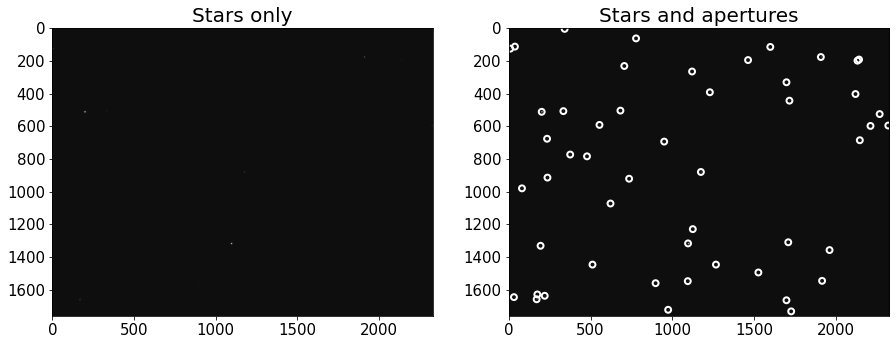

In [40]:
fig = plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.imshow(data, cmap='gray')

plt.title('Stars only'.format(df_star_stats), fontsize=20)

plt.subplot(1,2,2)
plt.imshow(data, cmap='gray')

plt.title('Stars and apertures'.format(df_star_stats), fontsize=20)
ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')

In [41]:
# Set up the aperture photometry.
CIRC_stats = ApertureStats(data, aperture)

In [42]:
# Find the total count (sum) within the circular apertures
df_star_stats['Sum of circulr aperture'] = CIRC_stats.sum

In [43]:
# Find the total area of the circular apertures
df_star_stats['Area of circular aperture'] = CIRC_stats.sum_aper_area.value  

In [44]:
df_star_stats

,xcenters,ycenters,Sum of circulr aperture,Area of circular aperture
0,201.184741,511.388259,29461.308338,1017.876020
1,1096.621211,1316.573815,28504.834796,1017.876020
2,1909.276856,176.050605,10665.692417,1017.876020
3,8.405526,124.929380,5983.896117,815.929577
4,170.234217,1658.351794,8284.087201,1017.876020
5,1175.312114,879.474263,7500.842879,1017.876020
6,2322.034810,595.238884,4352.555019,702.618731
7,333.793008,507.162940,4225.372241,1017.876020
8,219.554889,1637.051913,3920.554074,1017.876020
9,554.722209,591.406838,3333.235939,1017.876020


In [45]:
image_concat = []

image_concat = [fits.getdata(image) for image in image_list]

hdu_number = 0 # HDU means header data unit
image_hdr = [fits.getheader(image, hdu_number) for image in image_list]

In [46]:
N_images = np.shape(image_concat)
print(N_images) #shape of array, imagex X y-pixels X x-pixels
print(N_images[0]) #number of images

image_concat[0]

(55, 1760, 2328)
55


array([[0.9913126 , 1.2593195 , 0.8191063 , ..., 0.90089   , 1.3812749 ,
        1.4029639 ],
       [1.3304565 , 1.3318173 , 1.3984171 , ..., 1.1274515 , 1.2768856 ,
        0.74065274],
       [1.3040415 , 1.2879443 , 0.70256865, ..., 0.82786906, 1.0994904 ,
        1.355256  ],
       ...,
       [0.36864164, 1.0448354 , 0.54916006, ..., 1.1733968 , 0.8699955 ,
        0.7653589 ],
       [1.0765574 , 0.88071764, 0.8108508 , ..., 0.80181193, 1.2587005 ,
        0.67196345],
       [0.88039595, 0.79526824, 0.89654833, ..., 1.0698154 , 1.2222996 ,
        1.1293626 ]], dtype=float32)

In [47]:
for i in range(N_images[0]):
    image_concat[i] = image_concat[i] /16

In [48]:
exposures = np.zeros(N_images[0])

for n in range(N_images[0]):
    exposures[n] = image_hdr[n]["EXPTIME "]
print(exposures)
mean_exp = np.mean(exposures)
print(mean_exp)

[32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.
 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.
 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32. 32.
 32.]
32.0


In [49]:
image_hdr[0]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2328                                                  
NAXIS2  =                 1760                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'ZWO CCD ASI1600MM Pro' / CCD Name                                    
TELESCOP= 'SynScan '           / Telescope name                                 
OBSERVER= 'Unknown '           / Observer name                                  
OBJECT  = 'RV_UMa  '           / Object name                                    
EXPTIME =         3.200000E+

In [50]:
for n in range(N_images[0]):
    camera_temp = image_hdr[n]["CCD-TEMP"]
    print('Camera temp = ',str(camera_temp), ' C')

Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.5  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp =  -5.0  C
Camera temp

In [51]:
for n in range(N_images[0]):
    exposure = image_hdr[n]["EXPTIME "]
    print('Blue Filter Exposure time= ',str(exposure))

Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filter Exposure time=  32.0
Blue Filte

In [52]:
image_min = np.zeros(N_images[0])
image_max = np.zeros(N_images[0])
image_mean = np.zeros(N_images[0])
image_median = np.zeros(N_images[0])
image_stdev = np.zeros(N_images[0])

..\RV Uma\2022_03_20\Blue\Reduced_RV_Uma_Light_Blue_32_secs_055.fits
Min: -1.8635739088058472
Max: 32.97019577026367
Mean: 0.1583690494298935
Median 0.15673717856407166
Stdev: 0.13381454348564148


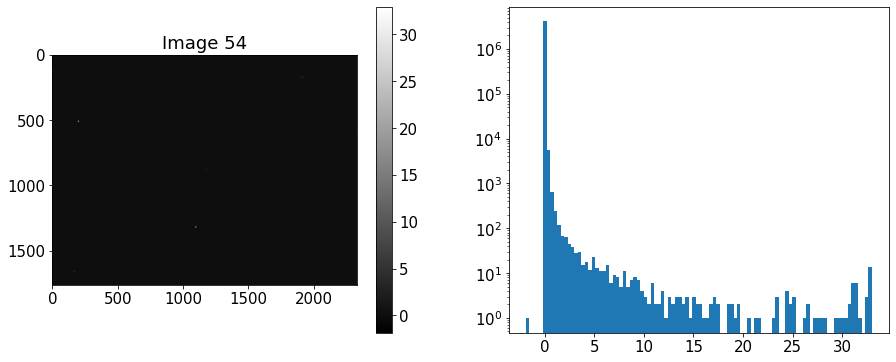

In [60]:
N_std = 0.2


for i in range(N_images[0]):
    clear_output(wait=True)

    plt.figure(figsize=(15,6))
    
    print(image_list[i])
    image_min[i] = np.min(image_concat[i])
    image_max[i] = np.max(image_concat[i])
    image_mean[i] = np.mean(image_concat[i])
    image_median[i] = np.median(image_concat[i])
    image_stdev[i] = np.std(image_concat[i])

    
    
    print('Min:', image_min[i] )
    print('Max:', image_max[i] )    
    print('Mean:', image_mean[i] )
    print('Median', image_median[i] )
    print('Stdev:', image_stdev[i] )


    
    plt.subplot(1,2,1)
    plt.imshow(image_concat[i], cmap='gray')#, 
#               vmin= image_mean[i] - N_std*image_stdev[i], vmax=image_mean[i] + N_std*image_stdev[i]) 
    plt.title("Image "+ str(i))
    plt.colorbar()


    plt.subplot(1,2,2)
    plt.hist(image_concat[i].flatten(),bins=100)
    plt.yscale('log')
  
    plt.show()
    
    time.sleep(10) #pause in secs. Make bigger if you need.


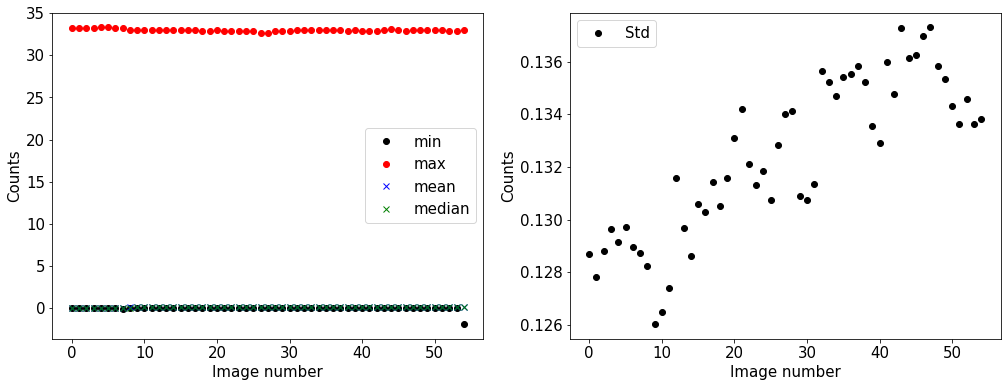

In [54]:
plt.figure(figsize=(17,6))

plt.subplot(1,2,1)
plt.plot(image_min,'ko',label='min')
plt.plot(image_max,'ro',label='max')
plt.plot(image_mean, 'bx', label='mean')
plt.plot(image_median,'gx',label='median')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()


plt.subplot(1,2,2)
plt.plot(image_stdev,'ko',label='Std')

plt.xlabel('Image number')
plt.ylabel('Counts')

plt.legend()



plt.show()



In [59]:
camera_temp = []
exposure = []
camera_filter = []

FILTER  = 'Luminance'

for n in range(N_images[0]):
    camera_temp.append(image_hdr[n]["CCD-TEMP"])
    exposure.append(image_hdr[n]["EXPTIME "])
    camera_filter.append(image_hdr[n]["FILTER "])

# need to do something for the std and master images etc.

mean_temp = np.mean(camera_temp)
mean_exposure = np.mean(exposure)


camera_temp.append(mean_temp)
camera_temp.append(mean_temp)
exposure.append(mean_exposure)
exposure.append(mean_exposure)
camera_filter.append(image_hdr[n]["FILTER "])
camera_filter.append(image_hdr[n]["FILTER "])

df_star_stats['Temp'] = camera_temp
df_star_stats['Exposure/s'] = exposure
df_star_stats['Filter '] = camera_filter

ValueError: Length of values (57) does not match length of index (50)